#Exploration of New York Subway Data 

_Timothy Lim_
***


###Overview
An introduction to ipython notebooks through the analysis of New York City subway data based on Udacity's [Intro to Data Science course](www.google.com). 

The data that will be used will be a csv file containing the information about entries to the New York Subway system for a given day, hour with details of the weather at the corresponding time. 

You can check out how to gather and clean the data in this ipython file.

***


###Examining the Data  

Setting up the workspace and importing the necessary modules.

In [373]:
%matplotlib inline

import numpy as np
from numpy import mean
import pandas
from pandas import *
from datetime import *

import scipy
import scipy.stats
import statsmodels.formula.api as smf

import ggplot
from ggplot import *
import matplotlib.pyplot as plt

import sys

Import the csv file containing the subway data and covert it to a pandas dataframe. Dataframes make it easy for us to manipulate the data and clean it for analysis. 

In [48]:
turnstile_df = pandas.read_csv('data/improved-dataset/turnstile_data_master_with_weather.csv')

Examine the file by printing the first five lines:

In [49]:
print turnstile_df.head()

   Unnamed: 0  UNIT       DATEn     TIMEn  Hour    DESCn  ENTRIESn_hourly  \
0           0  R001  2011-05-01  01:00:00     1  REGULAR                0   
1           1  R001  2011-05-01  05:00:00     5  REGULAR              217   
2           2  R001  2011-05-01  09:00:00     9  REGULAR              890   
3           3  R001  2011-05-01  13:00:00    13  REGULAR             2451   
4           4  R001  2011-05-01  17:00:00    17  REGULAR             4400   

   EXITSn_hourly  maxpressurei  maxdewpti   ...     meandewpti  meanpressurei  \
0              0         30.31         42   ...             39          30.27   
1            553         30.31         42   ...             39          30.27   
2           1262         30.31         42   ...             39          30.27   
3           3708         30.31         42   ...             39          30.27   
4           2501         30.31         42   ...             39          30.27   

   fog  rain  meanwindspdi  mintempi  meantempi  m

By quickly skimmming the dataframe we can note:
- Each measurement is taken every 4 hours
- Some weather events are binary (fog and rain) 


***

## Visualizing The Data

We can get a better idea of the data if we visualise it. The first plot we will be of the number of people using the subway for the different days of the week. 

In [217]:
def plot_usage_per_day(dataframe):
    
    aggregate_by_day = dataframe
       
    # Create a new column for the day of the week in the dataframe
    aggregate_by_day.loc[:,'Day'] = aggregate_by_day['DATEn']
    aggregate_by_day.loc[:,'Day'] = aggregate_by_day['Day'].map(lambda x:datetime.strptime(x, '%Y-%m-%d').strftime('%w'))
    aggregate_by_day = aggregate_by_day.groupby(['Day'], as_index=False).aggregate(mean)     

    # Specify the plot
    plot = ggplot(aggregate_by_day, aes(x='Day', y='ENTRIESn_hourly')) +\
    geom_line() +\
    ggtitle('NYC Subway ridership by day of week') +\
    xlab('Day') + ylab('Average Entries per Hour')+\
    theme_bw()+\
    scale_x_discrete(labels=("Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday")) 
    
    return plot

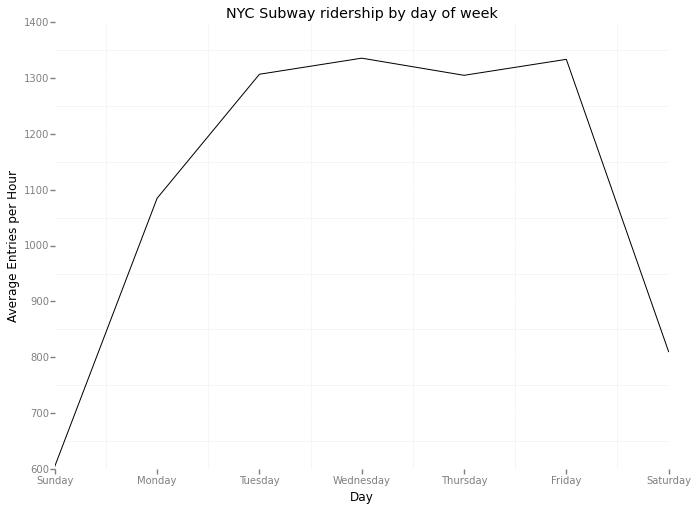

<ggplot: (281705341)>

In [218]:
plot_usage_per_day(turnstile_df)

As we can see above, the plot is what we would expect. Many more people use the subways on the weekdays than on the weekends.

We can look at the data more closely by plotting the number of entries for a given hour:

In [209]:
def plot_usage_per_hour(dataframe):
    
    aggregate_by_hour = dataframe
    aggregate_by_hour = aggregate_by_hour.groupby(['Hour'], as_index=False).aggregate(mean)
   
    
    plot = ggplot(aes(x='Hour', y = 'ENTRIESn_hourly'), data = aggregate_by_hour) +\
    geom_line() +\
    scale_x_continuous(limits=[0,23], breaks = range(0,24)) +\
    ggtitle('NYC Subway ridership by time of day') +\
    xlab('Hour (24-hr)') +\
    ylab('Entries') +\
    theme_bw()
    return plot

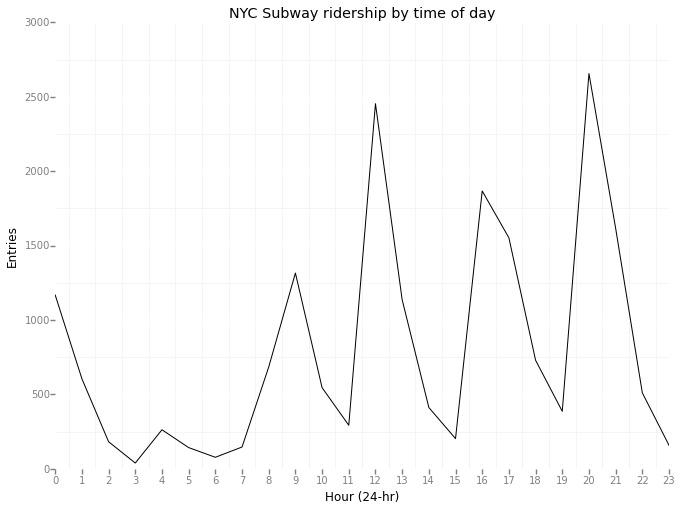

<ggplot: (282110337)>

In [210]:
plot_usage_per_hour(turnstile_df)

This plot throws up a few interesting features:
- There is a peak at midnight, are these people returning from social events or workers with late shifts?
- The peak at midday is actually larger than the typical times we would expect from rush hours (9 - 5)
- The communiting of early shift workers can be seen by the small bump at 4am
- The best time to travel is 3pm

***
## Does Rain Affect Subway Usage?


Using the combined data from weather underground and the new york subway, we can look at the relationship between weather and subway usage.

First, let's plot a histogram of to get a sense of how often people travel when it's raining and when it's not:

In [359]:
def entries_histogram(turnstile_weather):
     
    plt.figure()
    
    x=turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain']==1]
    y=turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain']==0]
    
    df = pandas.DataFrame({'Rain': x, 'No Rain': y})

    
    df.plot(kind='hist', alpha=0.75, bins=20, range=(0,6000))
    plt.xlabel('ENTRIESn_hourly')
    plt.ylabel('Frequency')
    plt.title('Histogram of ENTRIESn_hourly')
    
    return plt



<module 'matplotlib.pyplot' from '/Users/timothylim/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

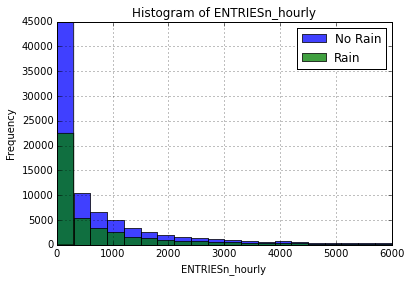

In [360]:
entries_histogram(turnstile_df)

We can see immediately that there are more entries to the subway when it is not raining. However, this may just mean that there are more clear days than rainy ones so we should not draw conclusions about usage patterns with regards to the weather. What we want to look at is the average number of entries for when it is raining and when it is not:

In [144]:
def average_entries(turnstile_weather):

    a = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain']==1]
    b = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain']==0]
    
    with_rain_mean = np.mean(a)
    without_rain_mean = np.mean(b)

    print 'Average number of entries with rain:' 
    print with_rain_mean
    print 'Average number of entries without rain:' 
    print without_rain_mean
    print 'Difference in percent'
    print with_rain_mean/without_rain_mean

In [145]:
average_entries(turnstile_df)

Average number of entries with rain:
1105.44637675
Average number of entries without rain:
1090.27878015
Difference in percent
1.01391166816


We can see a difference of 1.01% between the two averages. To check if this is a signifanct difference we have to apply a statistical test. From the histogram above we know that the data is skewed to the right, therefore we can apply the Mann-Whitney test:

In [152]:
def mann_whitney_plus_means(turnstile_weather):
    
    df = turnstile_weather
    a = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain']==1]
    b = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain']==0]
    
    with_rain_mean = np.mean(a)
    without_rain_mean = np.mean(b)
    
    U, p = scipy.stats.mannwhitneyu(a, b)
    
    print 'Mann-Whitney U-statistic:'
    print U
    print 'Mann-Whitney p value:'
    print p

In [153]:
mann_whitney_plus_means(turnstile_df)

Mann-Whitney U-statistic:
1924409167.0
Mann-Whitney p value:
0.0249999127935


"For the Mann-Whitney test, the null hypothesis is a bit hard to understand. The null hypothesis is that the distributions of both groups are identical, so that there is a 50% probability that an observation from a value randomly selected from one population exceeds an observation randomly selected from the other population."

Source : http://www.graphpad.com/guides/prism/6/statistics/index.htm?how_the_mann-whitney_test_works.htm 

We have a p value of 0.025 which means that we can say with 95% confidence that there is a difference between the two values.

For the Mann-Whitney U-statistic, the minimum value is 0 and the maximum is half of the product of the number of values in each dataset. For this case it would be 1937202044. A U-statistic of half of the maximum would imply that the null hypothesis is true. Since the calculated Mann-Whitney U is very close to the maximum we can say that the null hypothesis is false. 

***

##Modelling Subway Usage

We can model the usage of the subway by selecting variables, such as temperature or rain, and calculating their effect on ridership. Using a machine learning algorithm called 'gradient descent' we optimise the variables in a linear regression. 

The following functions calculate the predictions given a set of features. They are grouped together for ease of use:

In [223]:
def normalize_features(array):
   '''
   normalizes the features in the data set.
   '''
   mu = array.mean()
   sigma = array.std()
   array_normalized = (array - mu)/sigma

   return array_normalized, mu, sigma

def compute_cost(features, values, theta):
    '''
    computes the cost function given a set of features / values,
    and the values for our thetas.
    '''
    m = len(values)
    sum_of_square_errors = (np.square(np.dot(features, theta) - values)).sum()
    return sum_of_square_errors/2*m

def gradient_descent(features, values, theta, alpha, num_iterations):
    '''
    performs gradient descent given a data set with an arbitrary number
    of features.
    '''
    m = len(values)
    cost_history = []

    for i in range(num_iterations):
        predicted_values = np.dot(features, theta) - values
        theta = theta - (alpha/m) * np.dot(predicted_values, features)
        cost = compute_cost(features, values, theta)
        cost_history.append(cost)
    return theta, pandas.Series(cost_history)

def predictions(dataframe):
    '''
    runs predictions via gradient descent on turnstile dataframe
    '''
    # Select Features (try different features!)
    features = dataframe[['rain', 'precipi', 'meanwindspdi', 'meantempi']]

    # Add UNIT to features using dummy variables
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    print len(features)

    # Values
    values = dataframe['ENTRIESn_hourly']
    m = len(values)

    features, mu, sigma = normalize_features(features)
    features['ones'] = np.ones(m) # Add a column of 1s (y intercept)

    # Convert features and values to numpy arrays
    features_array = np.array(features)
    values_array = np.array(values)

    # Set values for alpha, number of iterations.
    alpha = 0.1 # please feel free to change this value
    num_iterations = 100 # please feel free to change this value

    # Initialize theta, perform gradient descent
    theta_gradient_descent = np.zeros(len(features.columns))
    theta_gradient_descent, cost_history = gradient_descent(features_array,
                                                            values_array,
                                                            theta_gradient_descent,
                                                            alpha,
                                                            num_iterations)
#     print theta_gradient_descent
    plot = plot_cost_history(alpha, cost_history)
    predictions = np.dot(features_array, theta_gradient_descent)
    return predictions, plot


def plot_cost_history(alpha, cost_history):
    '''
    returns plot of the cost history
    '''
    cost_df = pandas.DataFrame({
        'Cost_History': cost_history,
        'Iteration': range(len(cost_history))
    })
    return ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
        geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha ) + theme_bw()

In [221]:
df = turnstile_df
predicted, plot = predictions(turnstile_df)

131951


To check that the gradient descent has converged on a local minimum we plot the cost history:

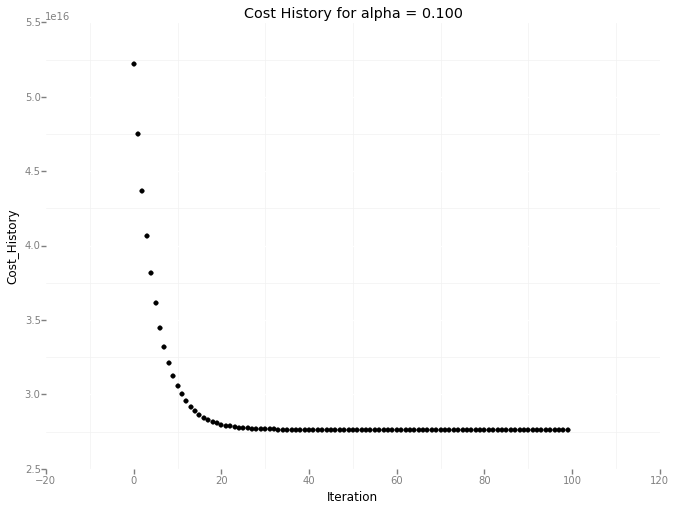

<ggplot: (284558205)>


In [222]:
print plot


The R^2 is a measure of how well a model explains the variation in the data. It is computed in the function below:

In [170]:
def compute_r_squared(data, predictions):

    r_squared = 1-(np.sum(np.square(data-predictions)))/\
                np.sum(np.square(data-np.mean(data)))

    return r_squared

In [154]:
compute_r_squared(df['ENTRIESn_hourly'], predicted)

0.41915839339741734

The model explains 41.9% of the variation present in the data. While this may seem like a low value, it is not the only way in which we can determine the quality of the model. Another way we could check how well we can predict variance is by plotting the residuals:

In [371]:
import math
def plot_residuals(turnstile_weather, predictions):
    '''
    makes a histogram of the residuals, the difference between the original
    hourly entry data and the predicted values)
    '''
    
    df = pandas.DataFrame((turnstile_weather['ENTRIESn_hourly'] - predictions))
    
    # Heuristic for calculating bin width
    x = len(df.index)
    bw = math.sqrt(x)   
    
    plot = ggplot(aes(x = 'ENTRIESn_hourly'), data=df) +\
    scale_x_continuous(limits=[-4000,8000]) +\
    geom_histogram(binwidth = 100) +\
    theme_bw()
    
    print plot

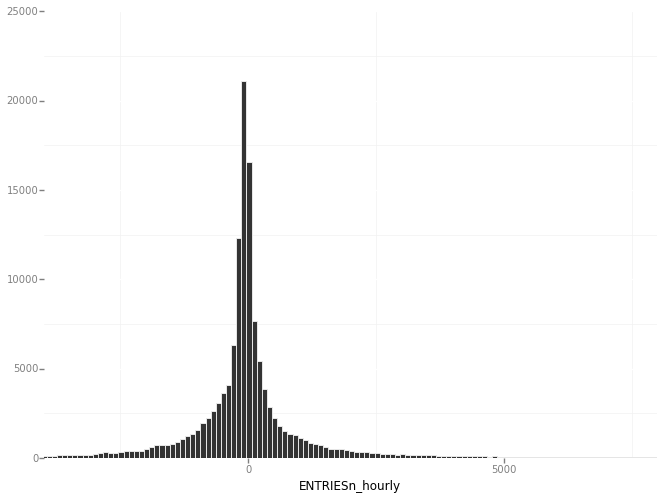

<ggplot: (790958289)>


In [372]:
plot_residuals(df, predicted)

The residuals follow a normal distribution and thus we can be confident that the underlying assumptions of the model are sound. While an R^2 value of 41.9% may be too low to consider this linear regression to be completely accurate, it serves as a decent measure for approximating ridership of the New York subway.

***
###Additional Reading

[Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)

